# Multi-Layer Fully Connected Network
In this exercise, you will implement a fully connected network with an arbitrary number of hidden layers.

In [78]:
# from google.colab import drive
# drive.mount('/content/drive')

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the network initialization, forward pass, and backward pass. Throughout this assignment, you will be implementing layers in `cs231n/layers.py`. You can re-use your implementations for `affine_forward`, `affine_backward`, `relu_forward`, `relu_backward`, and `softmax_loss` from before. For right now, don't worry about implementing dropout or batch/layer normalization yet, as you will add those features later.


In [79]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


## Initial Loss and Gradient Check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

In [81]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    # Most of the errors should be on the order of e-7 or smaller.
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 7.696803870986541e-08
W2 relative error: 1.7087519140575808e-05
W3 relative error: 2.9508423118300657e-07
b1 relative error: 4.660094650186831e-09
b2 relative error: 2.085654124402131e-09
b3 relative error: 6.598642296022133e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 3.904542008453064e-09
W2 relative error: 6.86942277940646e-08
W3 relative error: 2.1311298702113723e-08
b1 relative error: 1.1683196894962977e-08
b2 relative error: 1.7223751746766738e-09
b3 relative error: 1.3200479211447775e-10


As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.363364
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.108000
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.127000
(Epoch 2 / 20) train acc: 0.440000; val_acc: 0.172000
(Epoch 3 / 20) train acc: 0.500000; val_acc: 0.184000
(Epoch 4 / 20) train acc: 0.540000; val_acc: 0.181000
(Epoch 5 / 20) train acc: 0.740000; val_acc: 0.190000
(Iteration 11 / 40) loss: 0.839976
(Epoch 6 / 20) train acc: 0.740000; val_acc: 0.187000
(Epoch 7 / 20) train acc: 0.740000; val_acc: 0.183000
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.177000
(Epoch 9 / 20) train acc: 0.860000; val_acc: 0.200000
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.191000
(Iteration 21 / 40) loss: 0.337174
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.189000
(Epoch 12 / 20) train acc: 0.940000; val_acc: 0.180000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.195000
(Iteration 31 / 40) loss: 

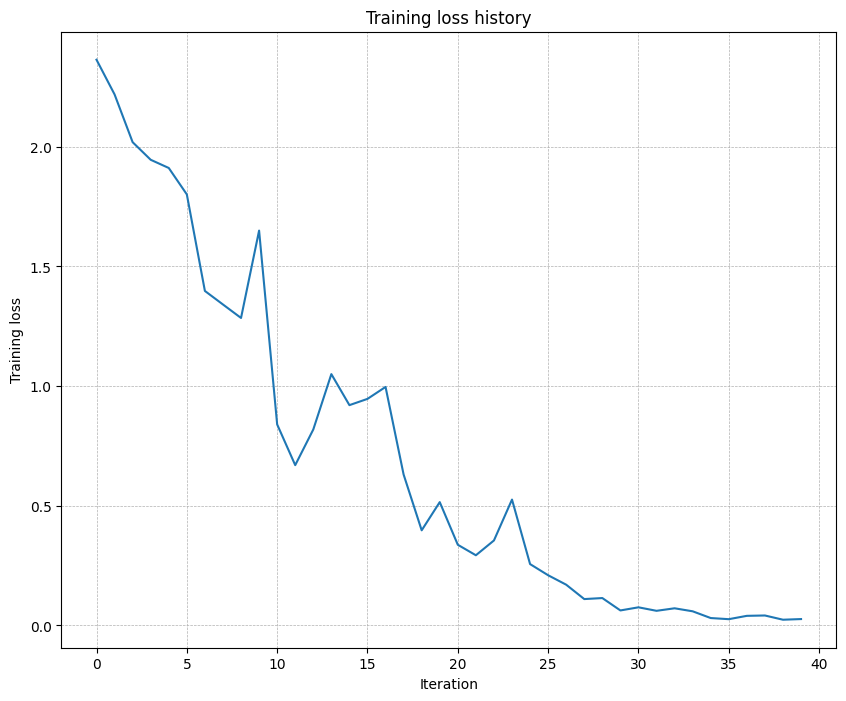

In [82]:
# TODO: Use a three-layer Net to overfit 50 training examples by
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

weight_scale = 1e-2   # Experiment with this!
learning_rate = 1e-2  # Experiment with this!


model = FullyConnectedNet(
    [100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule="sgd",
    optim_config={"learning_rate": learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

Now, try to use a five-layer network with 100 units on each layer to overfit on 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

训练模型 1/100, learning_rate=0.010000,weight_scale=0.010000
训练模型 2/100, learning_rate=0.010000,weight_scale=0.012915
训练模型 3/100, learning_rate=0.010000,weight_scale=0.016681
训练模型 4/100, learning_rate=0.010000,weight_scale=0.021544
训练模型 5/100, learning_rate=0.010000,weight_scale=0.027826
训练模型 6/100, learning_rate=0.010000,weight_scale=0.035938
训练模型 7/100, learning_rate=0.010000,weight_scale=0.046416
训练模型 8/100, learning_rate=0.010000,weight_scale=0.059948
训练模型 9/100, learning_rate=0.010000,weight_scale=0.077426


d:\GitProjects\CS231n\assignments\assignment1\cs231n\layers.py:699: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(p[np.arange(N), y]))
d:\GitProjects\CS231n\assignments\assignment1\cs231n\layers.py:697: RuntimeWarning: overflow encountered in exp
  p = np.exp(s)
d:\GitProjects\CS231n\assignments\assignment1\cs231n\layers.py:698: RuntimeWarning: invalid value encountered in divide
  p /= p.sum(axis=1, keepdims=True)


训练模型 10/100, learning_rate=0.010000,weight_scale=0.100000
训练模型 11/100, learning_rate=0.012915,weight_scale=0.010000
训练模型 12/100, learning_rate=0.012915,weight_scale=0.012915
训练模型 13/100, learning_rate=0.012915,weight_scale=0.016681
训练模型 14/100, learning_rate=0.012915,weight_scale=0.021544
训练模型 15/100, learning_rate=0.012915,weight_scale=0.027826
训练模型 16/100, learning_rate=0.012915,weight_scale=0.035938
训练模型 17/100, learning_rate=0.012915,weight_scale=0.046416
训练模型 18/100, learning_rate=0.012915,weight_scale=0.059948
训练模型 19/100, learning_rate=0.012915,weight_scale=0.077426
训练模型 20/100, learning_rate=0.012915,weight_scale=0.100000
训练模型 21/100, learning_rate=0.016681,weight_scale=0.010000
训练模型 22/100, learning_rate=0.016681,weight_scale=0.012915
训练模型 23/100, learning_rate=0.016681,weight_scale=0.016681
训练模型 24/100, learning_rate=0.016681,weight_scale=0.021544
训练模型 25/100, learning_rate=0.016681,weight_scale=0.027826
训练模型 26/100, learning_rate=0.016681,weight_scale=0.035938
训练模型 27/100, l

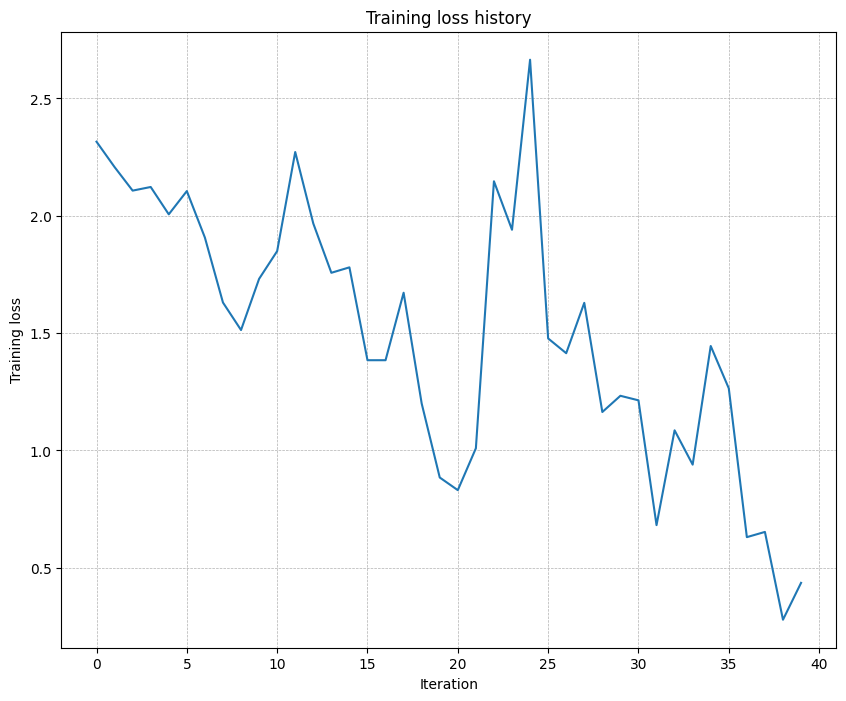

In [83]:
# TODO: Use a five-layer Net to overfit 50 training examples by
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

# learning_rate = 1e-2  # Experiment with this! 
# weight_scale = 1e-2   # Experiment with this!
# 对原代码做了一些更改以保存最好的solver
best_val_accuracy = 0
best_learning_rate = 0
best_weight_scale = 0
best_train_accuracy = 0
best_model = None
best_solver = None

model_count = 0

for learning_rate in np.logspace(-2, -1, 10):
    for weight_scale in np.logspace(-2, -1, 10):
      model_count += 1
      print(f"训练模型 {model_count}/{100}, learning_rate={learning_rate:.6f},weight_scale={weight_scale:.6f}")
      
      model = FullyConnectedNet(
          [100, 100, 100, 100],
          weight_scale=weight_scale,
          dtype=np.float64
      )
      solver = Solver(
          model,
          small_data,
          print_every=10,
          num_epochs=20,
          batch_size=25,
          update_rule='sgd',
          optim_config={'learning_rate': learning_rate},
          verbose=False 
      )
      solver.train()
      
      # 获取当前模型的训练准确率
      current_train_accuracy = max(solver.train_acc_history)
      
      if solver.best_val_acc > best_val_accuracy:
        best_solver = solver
        best_model = model
        best_val_accuracy = solver.best_val_acc
        best_learning_rate = learning_rate
        best_weight_scale = weight_scale
        best_train_accuracy = current_train_accuracy

# 输出最优模型的参数        
print("\n最优模型参数:")
print("最佳验证准确率: ", best_val_accuracy)
print("最佳训练准确率: ", best_train_accuracy)
print("最佳学习率: ", best_learning_rate)
print("最佳权重初始化比例: ", best_weight_scale)

# 输出最优模型的训练历史
print("\n最优模型训练历史:")
for epoch, (train_acc, val_acc) in enumerate(zip(best_solver.train_acc_history, best_solver.val_acc_history)):
    print(f"Epoch {epoch+1}: 训练准确率 = {train_acc:.4f}, 验证准确率 = {val_acc:.4f}")

# 绘制最优模型的损失曲线
plt.plot(best_solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()



**Inline Question 1**

Did you notice anything about the comparative difficulty of training the three-layer network vs. training the five-layer network? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

您是否注意到训练三层网络与训练五层网络在难度上的差异？特别是根据您的经验，哪个网络对初始化比例更敏感？您认为这是为什么？

$\color{blue}{\textit Your Answer:}$

A: 五层网络对初始化比例更敏感. 看调参过程2和3可以看出来当weight_scale从0.027 -> 0.1后loss从2->80.

原因在于梯度消失／爆炸问题. 网络越深，反向传播时梯度要经过更多层的连乘. 如果初始化值偏大，每一层的梯度或激活都会放大，最后容易梯度爆炸；如果初始化值偏小, 损失函数又设计不当, 梯度又容易在多层累乘中缩减到接近 0. 

梯度消失比梯度爆炸更常见. 梯度爆炸很快会导致数值溢出(NaN/Inf)，引起明显错误并终止训练. 而梯度消失则表现为训练停滞, 不易被发现.




# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [84]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

Running with  sgd
(Iteration 1 / 200) loss: 3.282996
(Epoch 0 / 5) train acc: 0.124000; val_acc: 0.124000
(Iteration 11 / 200) loss: 2.283356
(Iteration 21 / 200) loss: 2.188060
(Iteration 31 / 200) loss: 2.156987
(Epoch 1 / 5) train acc: 0.238000; val_acc: 0.231000
(Iteration 41 / 200) loss: 2.168704
(Iteration 51 / 200) loss: 2.131762
(Iteration 61 / 200) loss: 1.960235
(Iteration 71 / 200) loss: 1.921929
(Epoch 2 / 5) train acc: 0.318000; val_acc: 0.266000
(Iteration 81 / 200) loss: 1.904214
(Iteration 91 / 200) loss: 1.942064
(Iteration 101 / 200) loss: 1.982745
(Iteration 111 / 200) loss: 1.947362
(Epoch 3 / 5) train acc: 0.319000; val_acc: 0.309000
(Iteration 121 / 200) loss: 1.886175
(Iteration 131 / 200) loss: 1.715382
(Iteration 141 / 200) loss: 1.739583
(Iteration 151 / 200) loss: 1.735427
(Epoch 4 / 5) train acc: 0.360000; val_acc: 0.308000
(Iteration 161 / 200) loss: 1.916189
(Iteration 171 / 200) loss: 1.787305
(Iteration 181 / 200) loss: 1.928009
(Iteration 191 / 200) los

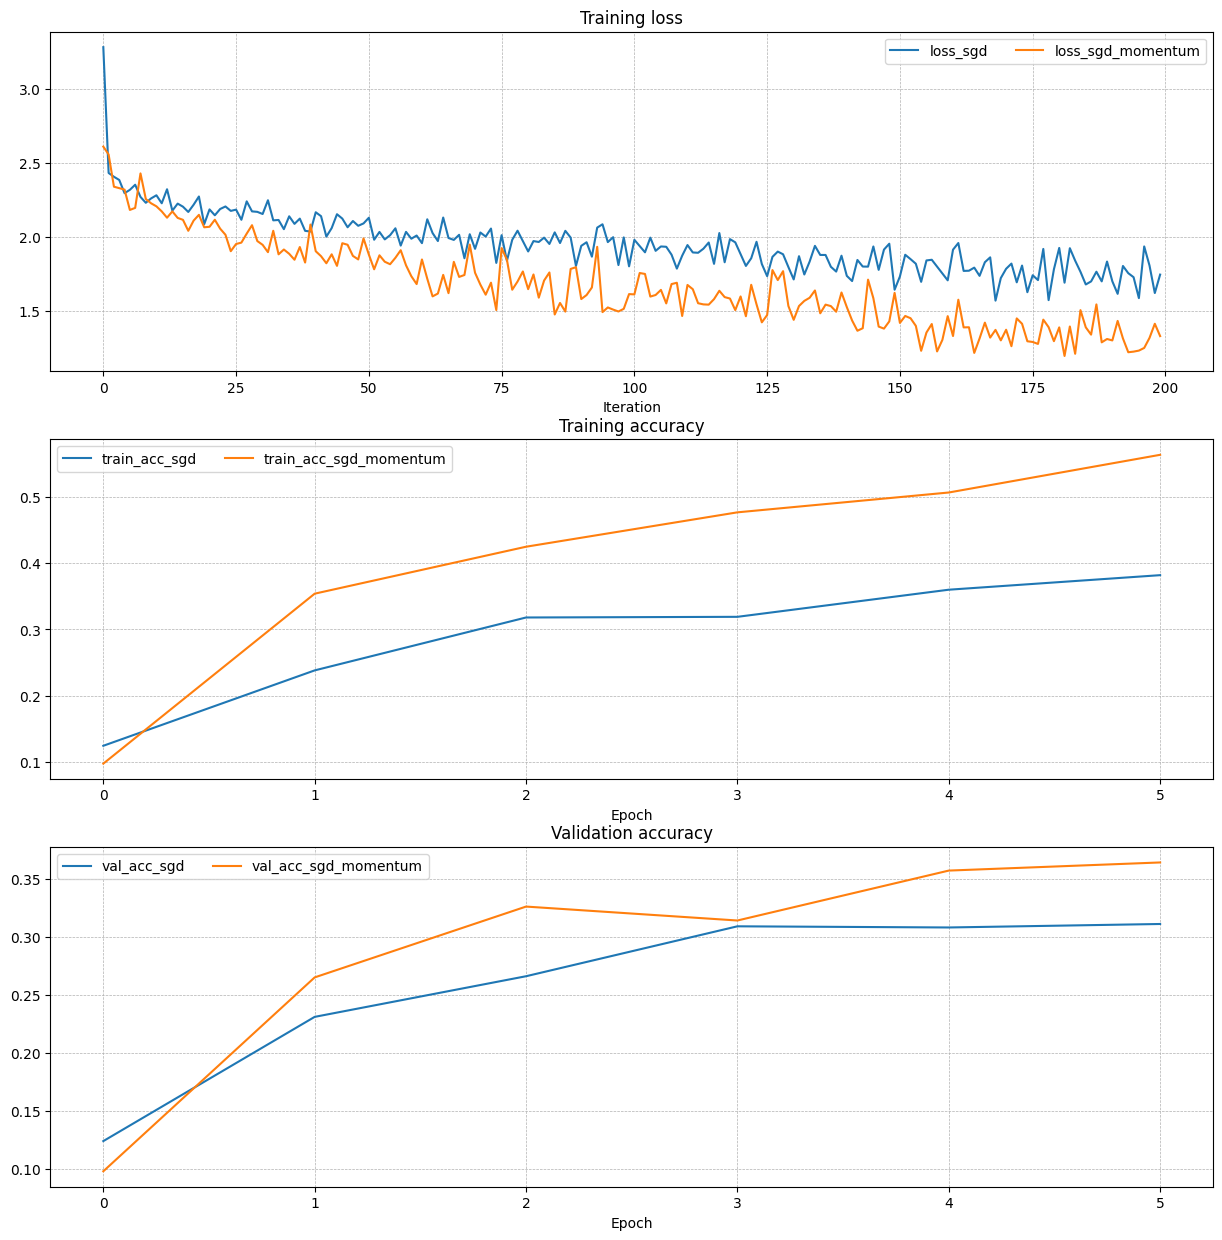

In [85]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")

for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [86]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [87]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

Running with  adam
(Iteration 1 / 200) loss: 2.836684
(Epoch 0 / 5) train acc: 0.125000; val_acc: 0.105000
(Iteration 11 / 200) loss: 2.239296
(Iteration 21 / 200) loss: 2.013321
(Iteration 31 / 200) loss: 1.840349
(Epoch 1 / 5) train acc: 0.332000; val_acc: 0.302000
(Iteration 41 / 200) loss: 1.741132
(Iteration 51 / 200) loss: 1.840344
(Iteration 61 / 200) loss: 1.775202
(Iteration 71 / 200) loss: 1.701102
(Epoch 2 / 5) train acc: 0.410000; val_acc: 0.352000
(Iteration 81 / 200) loss: 1.638657
(Iteration 91 / 200) loss: 1.593398
(Iteration 101 / 200) loss: 1.364199
(Iteration 111 / 200) loss: 1.605214
(Epoch 3 / 5) train acc: 0.477000; val_acc: 0.369000
(Iteration 121 / 200) loss: 1.672527
(Iteration 131 / 200) loss: 1.287021
(Iteration 141 / 200) loss: 1.191206
(Iteration 151 / 200) loss: 1.213019
(Epoch 4 / 5) train acc: 0.540000; val_acc: 0.357000
(Iteration 161 / 200) loss: 1.258409
(Iteration 171 / 200) loss: 1.268487
(Iteration 181 / 200) loss: 1.455514
(Iteration 191 / 200) lo

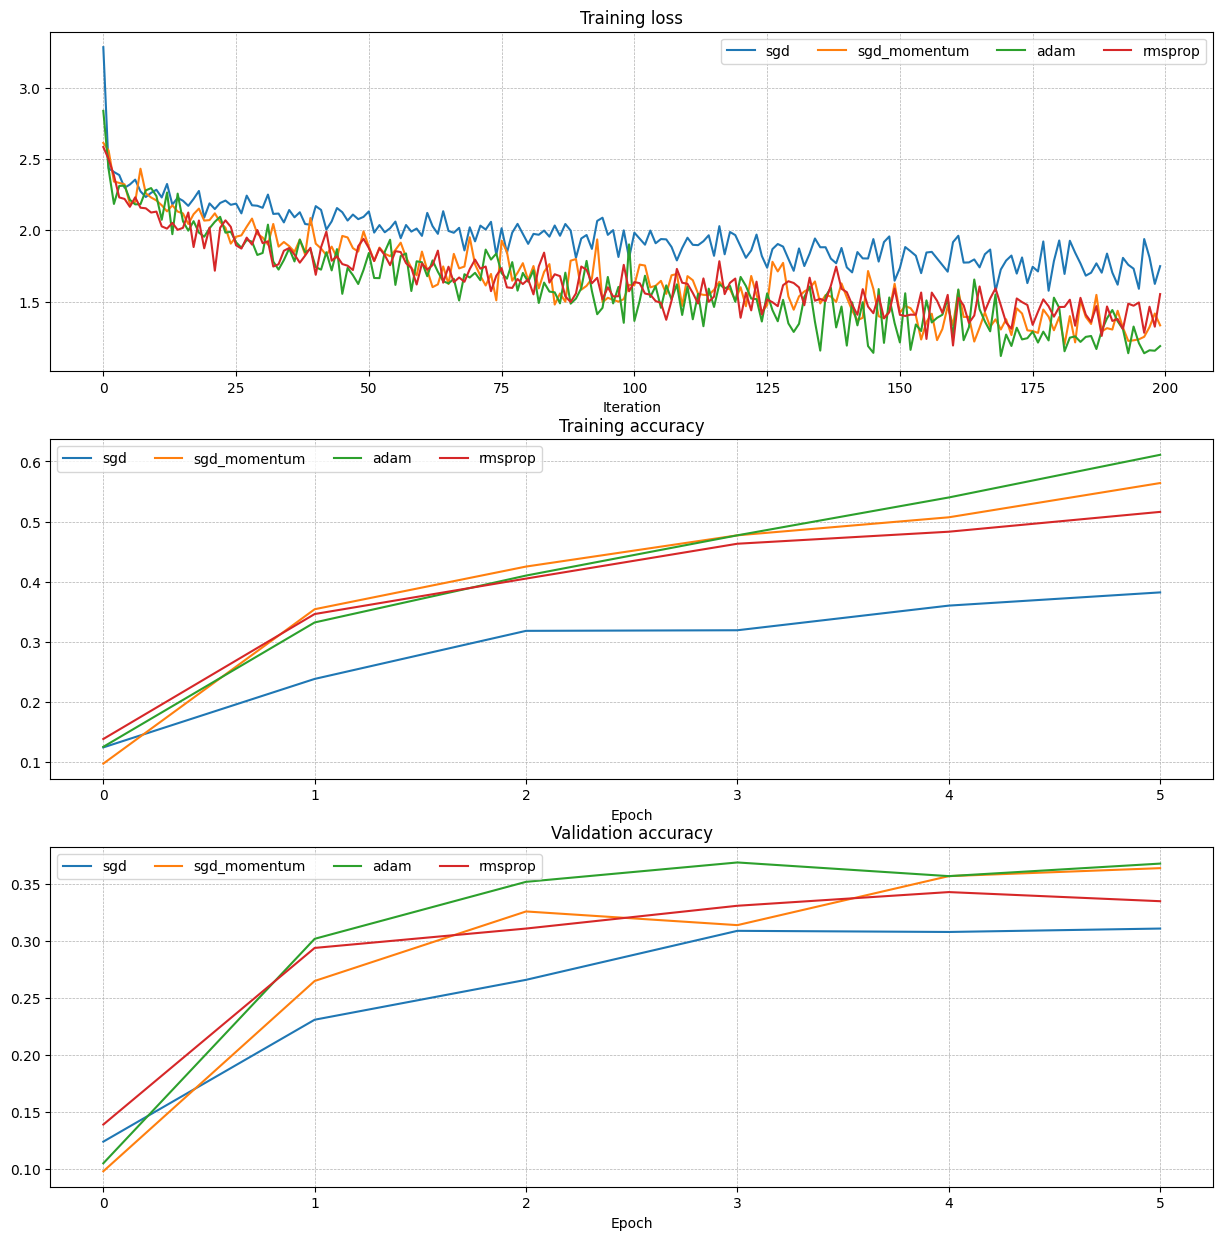

In [88]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': learning_rates[update_rule]},
        verbose=True
    )
    solvers[update_rule] = solver
    solver.train()
    print()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")

for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

**Inline Question 2**

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

>
> ```
>cache += dw**2
> 
>w += - learning_rate * dw / (np.sqrt(cache) + eps)
> ```
>

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?

AdaGrad和Adam一样，是一种按参数优化方法，它使用以下更新规则：

Cache += dw**2

W += - learning_rate * dw / （np.sqrt(cache) + eps）

John注意到，当他用AdaGrad训练一个网络时，更新变得非常小，他的网络学习很慢。根据

你对AdaGrad更新规则的了解，为什么你认为更新会变得非常小？Adam会有同样的问题吗？

$\color{blue}{\textit Your Answer:}$

AdaGrad 的核心在于对每个参数都维护一个累积的二阶矩（梯度平方）变量，当这个累积量不断增大时，导致有效学习率被压得越来越小。

AdaGrad 在第 i 步的更新规则为：
$$
\text{G}_i = \text{G}_{i-1} + (dw_i)^2
 \\W_{i+1} = W_i - \frac{\eta}{\sqrt{\text{G}_i} + \varepsilon}dw_i,
$$
其中 $\eta$ 是初始学习率，$\varepsilon$ 防止分母为零。

而Adam 在累积二阶矩时采用的是指数衰减平均：
$$
\hat v_3
= \frac{\beta_2^2\,(dw_1)^2 \;+\;\beta_2\,(dw_2)^2\;+\;(dw_3)^2}
       {1+\beta_2+\beta_2^2}
$$
两种算法对比，AdaGrad 能自适应地为每个参数调节步长，对频繁更新的参数步长更小，对不常更新的参数步长相对更大，但同时也会因为累积过多历史信息而导致后期步长过小。Adam 则通过指数加权和平滑校正，有效避免了这一问题。




# Train a Good Model!
Train the best fully connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully connected network.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the next assignment, we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional networks rather than fully connected networks.

**Note:** In the next assignment, you will learn techniques like BatchNormalization and Dropout which can help you train powerful models.

Training model 1 with learning_rate=0.0001, weight_scale=1e-05
Training model 2 with learning_rate=0.0001, weight_scale=2.1544346900318823e-05
Training model 3 with learning_rate=0.0001, weight_scale=4.641588833612782e-05
Training model 4 with learning_rate=0.0001, weight_scale=0.0001
Training model 5 with learning_rate=0.00021544346900318845, weight_scale=1e-05
Training model 6 with learning_rate=0.00021544346900318845, weight_scale=2.1544346900318823e-05
Training model 7 with learning_rate=0.00021544346900318845, weight_scale=4.641588833612782e-05
Training model 8 with learning_rate=0.00021544346900318845, weight_scale=0.0001
Training model 9 with learning_rate=0.00046415888336127773, weight_scale=1e-05
Training model 10 with learning_rate=0.00046415888336127773, weight_scale=2.1544346900318823e-05
Training model 11 with learning_rate=0.00046415888336127773, weight_scale=4.641588833612782e-05
Training model 12 with learning_rate=0.00046415888336127773, weight_scale=0.0001
Training mo

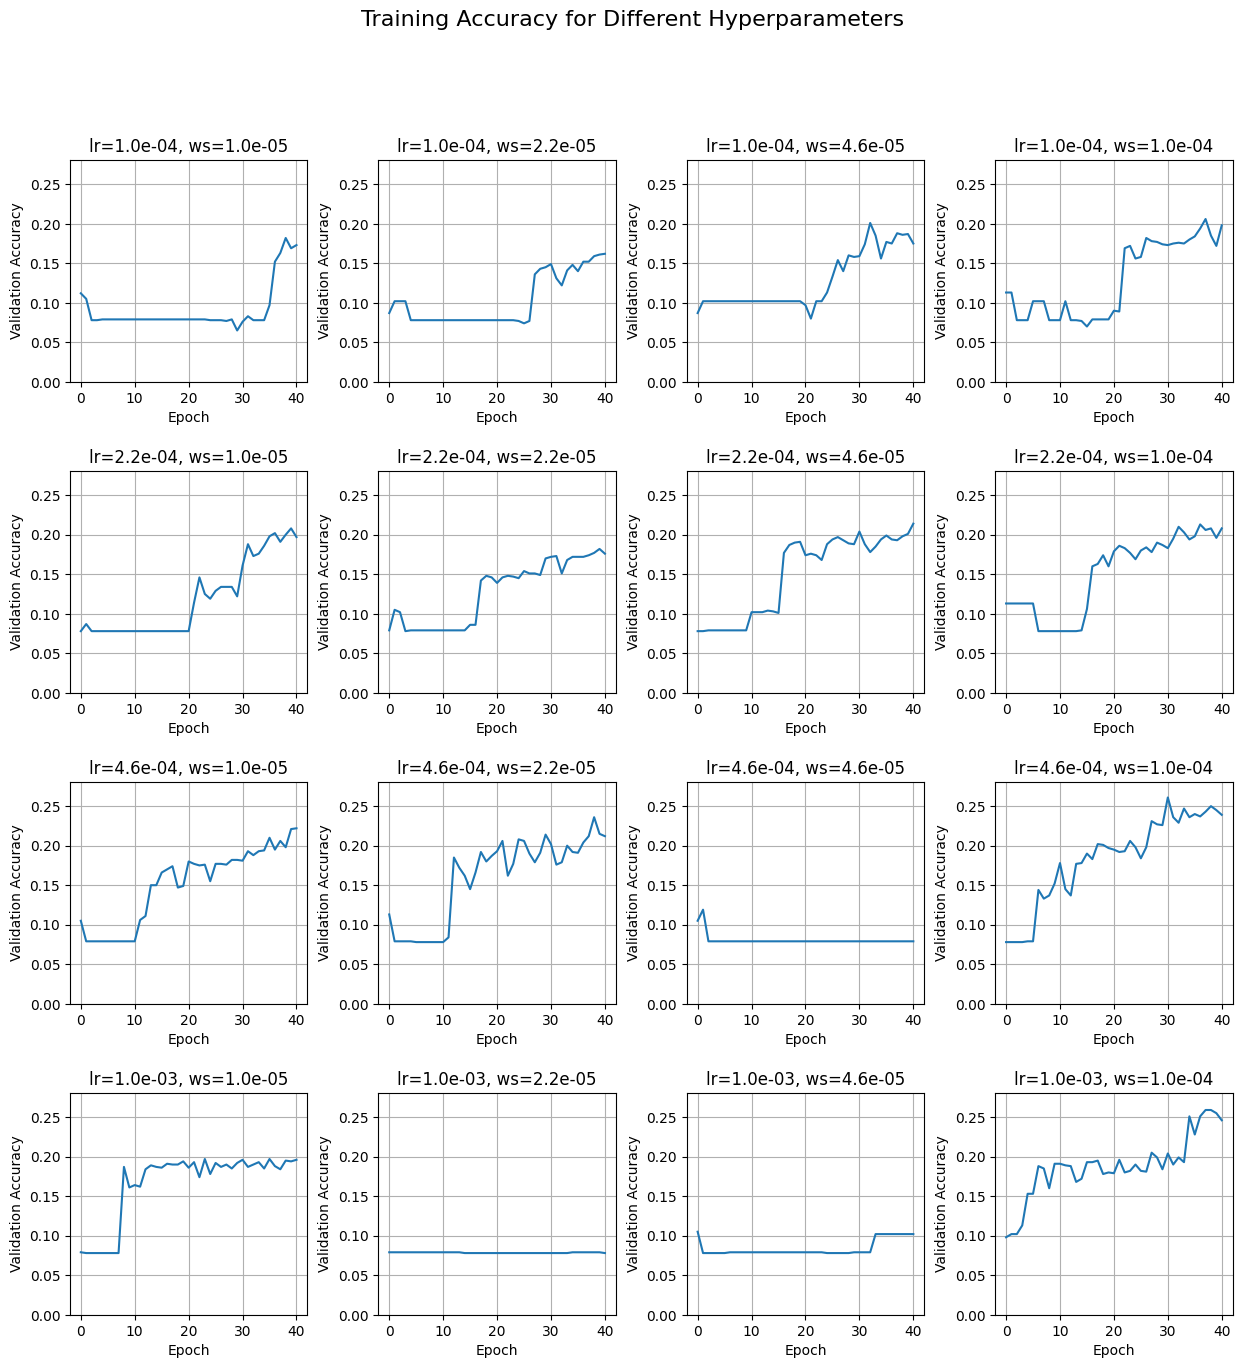

In [ ]:
best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# data
num_train = 4096
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

# plot_init
# 创建一个图表来显示不同参数组合的训练准确率
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
fig.suptitle('Training Accuracy for Different Hyperparameters', fontsize=16)
axes = axes.flatten()
# 增加子图之间的间距
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plot_idx = 0

# best_model_params_init
best_val_acc = -1
best_model = None
best_learning_rate = 0
best_weight_scale = 0
all_val_accs = []
models_results = []

# params_init
num_epochs = 40
batch_size = 1024
hidden_dims = [256, 128, 64, 32]
for learning_rate in np.logspace(-4, -3, 4):
    for weight_scale in np.logspace(-5, -4, 4):
        
        # model_init
        model = FullyConnectedNet(
            hidden_dims,
            weight_scale = weight_scale
        )
        # solver_init
        solver = Solver(
            model,
            small_data,
            num_epochs=num_epochs,
            batch_size=batch_size,
            update_rule='adam',
            optim_config={'learning_rate': learning_rate},
            verbose=False
        )
        # train
        print(f"Training model {plot_idx+1} with learning_rate={learning_rate}, weight_scale={weight_scale}")
        solver.train()

        # plot_data
        all_val_accs.extend(solver.val_acc_history)
        models_results.append((model, solver, learning_rate, weight_scale))
        # choose best_model
        # 还没有学到batchnorm和dropout, 在这里使用比较朴素的方式选取两个在small_data上表现较好的learning_rate和weight_scale. 
        val_acc = solver.val_acc_history[-1]
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model
            best_learning_rate = learning_rate
            best_weight_scale = weight_scale
        plot_idx += 1

# plot
# 确定所有子图的y轴范围
y_min = 0
y_max = max(all_val_accs)+0.02
# 绘制所有子图
for idx, (model, solver, learning_rate, weight_scale) in enumerate(models_results):
    ax = axes[idx]
    ax.plot(solver.val_acc_history)
    ax.set_title(f'lr={learning_rate:.1e}, ws={weight_scale:.1e}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Accuracy')
    ax.set_ylim(y_min, y_max)
    ax.grid(True)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 2200) loss: 2.302585
(Epoch 0 / 200) train acc: 0.109000; val_acc: 0.102000
(Iteration 11 / 2200) loss: 2.302574
(Epoch 1 / 200) train acc: 0.095000; val_acc: 0.102000
(Iteration 21 / 2200) loss: 2.302773
(Epoch 2 / 200) train acc: 0.098000; val_acc: 0.102000
(Iteration 31 / 2200) loss: 2.302566
(Epoch 3 / 200) train acc: 0.116000; val_acc: 0.102000
(Iteration 41 / 2200) loss: 2.302634
(Epoch 4 / 200) train acc: 0.115000; val_acc: 0.102000
(Iteration 51 / 2200) loss: 2.302483
(Epoch 5 / 200) train acc: 0.119000; val_acc: 0.102000
(Iteration 61 / 2200) loss: 2.302572
(Epoch 6 / 200) train acc: 0.110000; val_acc: 0.079000
(Iteration 71 / 2200) loss: 2.302826
(Epoch 7 / 200) train acc: 0.093000; val_acc: 0.079000
(Iteration 81 / 2200) loss: 2.302639
(Epoch 8 / 200) train acc: 0.093000; val_acc: 0.079000
(Iteration 91 / 2200) loss: 2.302690
(Epoch 9 / 200) train acc: 0.088000; val_acc: 0.079000
(Iteration 101 / 2200) loss: 2.302674
(Epoch 10 / 200) train acc: 0.091000; val_a

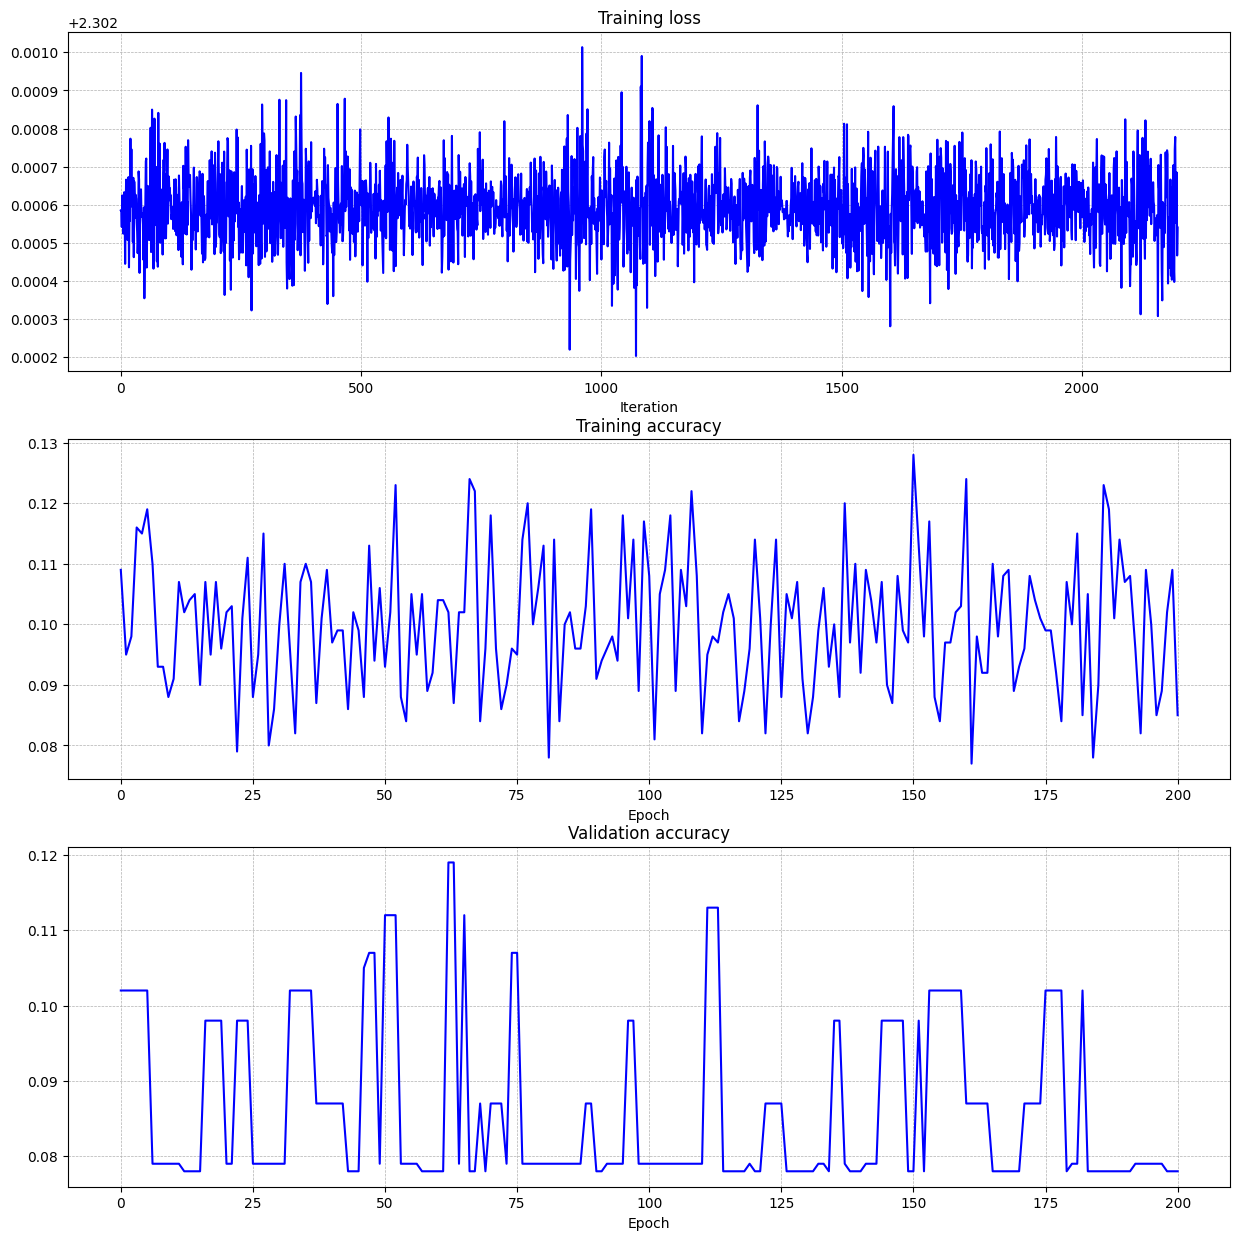

In [104]:
# train a model on CIFAR-10
# params_init
num_epochs = 50
batch_size = 1024
learning_rate = 1e-3
weight_scale = 1e-4
hidden_dims = [256, 128, 64, 32]
# model_init
model = FullyConnectedNet(
    hidden_dims,
    weight_scale = weight_scale
)
# solver_init
solver = Solver(
    model,
    data,
    num_epochs=num_epochs,
    batch_size=batch_size,
    update_rule='adam',
    optim_config={'learning_rate': learning_rate},
    verbose=True
)
# train
solver.train()

# plt loss
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

axes[0].plot(solver.loss_history, 'b')
axes[1].plot(solver.train_acc_history, 'b')
axes[2].plot(solver.val_acc_history, 'b')

for ax in axes:
    ax.grid(linestyle='--', linewidth=0.5)

best_model = model


# Test Your Model!
Run your best model on the validation and test sets. You should achieve at least 50% accuracy on the validation set and the test set.

In [102]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.532
Test set accuracy:  0.526
